In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import glob
import os
import tensorflow as tf
from tensorflow.keras import layers, Sequential

In [3]:
import os
import cv2
import time
import shutil
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
sns.set_style('darkgrid')
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
print ('modules loaded')

modules loaded


In [4]:
import os
import shutil
import random

def split_data(source_dir, train_dir, validation_dir, test_dir, split_ratio=(0.8, 0.1, 0.1)):
    # Create target directories if they don't exist
    for directory in [train_dir, validation_dir, test_dir]:
        if not os.path.exists(directory):
            os.makedirs(directory)

    # Get list of all image filenames
    filenames = os.listdir(source_dir)
    # Shuffle the filenames to ensure randomness
    random.shuffle(filenames)

    # Calculate split sizes
    num_files = len(filenames)
    num_train = int(num_files * split_ratio[0])
    num_validation = int(num_files * split_ratio[1])

    # Split the filenames
    train_filenames = filenames[:num_train]
    validation_filenames = filenames[num_train:num_train + num_validation]
    test_filenames = filenames[num_train + num_validation:]

    # Move files to respective directories
    move_files(train_filenames, source_dir, train_dir)
    move_files(validation_filenames, source_dir, validation_dir)
    move_files(test_filenames, source_dir, test_dir)

def move_files(filenames, source_dir, target_dir):
    for filename in filenames:
        source_path = os.path.join(source_dir, filename)
        target_path = os.path.join(target_dir, filename)
        shutil.copyfile(source_path, target_path)


source_directory = "/content/drive/MyDrive/DROUGHT PROJECT/Drought"
train_directory = "/content/drive/MyDrive/DROUGHT PROJECT/train"
validation_directory = "/content/drive/MyDrive/DROUGHT PROJECT/validation"
test_directory = "/content/drive/MyDrive/DROUGHT PROJECT/test"

split_data(source_directory, train_directory, validation_directory, test_directory)


In [5]:
import os

def count_items(directory):
    counts = {}
    for dirpath, _, filenames in os.walk(directory):
        # Count files
        file_count = len(filenames)
        # Count subdirectories
        dir_count = sum(os.path.isdir(os.path.join(dirpath, d)) for d in filenames)
        # Store counts for the current directory
        counts[dirpath] = {'files': file_count, 'directories': dir_count}
    return counts

# Example usage
train_counts = count_items(train_directory)
print("Train Directory Counts:")
print(train_counts)

validation_counts = count_items(validation_directory)
print("Validation Directory Counts:")
print(validation_counts)

test_counts = count_items(test_directory)
print("Test Directory Counts:")
print(test_counts)


Train Directory Counts:
{'/content/drive/MyDrive/DROUGHT PROJECT/train': {'files': 209, 'directories': 0}}
Validation Directory Counts:
{'/content/drive/MyDrive/DROUGHT PROJECT/validation': {'files': 26, 'directories': 0}}
Test Directory Counts:
{'/content/drive/MyDrive/DROUGHT PROJECT/test': {'files': 27, 'directories': 0}}


In [6]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import glob

# Defined the image dimensions
img_height = 360
img_width = 360
batch_size = 32

# Defined the base directory containing image folders
base_directory = '/content/drive/MyDrive/DROUGHT PROJECT'

# Created an empty list to store image paths from all three folders
image_paths = []

# Loop through each folder (test, valid, and train)
for folder in ['test', 'valid', 'train']:
    # Defined the directory for the current folder
    folder_directory = os.path.join(base_directory, folder)

    # Used glob to automatically discover image files within the folder
    folder_image_paths = glob.glob(os.path.join(folder_directory, '*.jpg'))  # Assumes your images are in JPEG format

    # Filter out any directory paths
    folder_image_paths = [path for path in folder_image_paths if os.path.isfile(path)]

    # Appended the image paths from the current folder to the list
    image_paths.extend(folder_image_paths)

# Defined a pre-trained ResNet50 model for feature extraction
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_height, img_width, 3)))

# Created a new model with the ResNet50 base and global average pooling
model = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

# Feature extraction for each image
image_features = []

for image_path in image_paths:
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.resnet.preprocess_input(img)
    feature = model.predict(img)
    image_features.append(feature)

print("Number of features extracted:", len(image_features))

# To Check if any features are extracted
if not image_features:
    print("No features were extracted from the images. Please check the image paths and feature extraction process.")
else:
    image_features = np.concatenate(image_features, axis=0)

    # Calculate pairwise cosine similarity between images
    cosine_similarities = cosine_similarity(image_features)

    # Set a threshold for similarity below which images are considered duplicates
    similarity_threshold = 0.1

    # Find duplicate pairs of images
    duplicates = set()
    for i in range(len(image_paths)):
        for j in range(i + 1, len(image_paths)):
            if cosine_similarities[i, j] > similarity_threshold:
                duplicates.add((i, j))

    # Remove duplicate images from your dataset
    deduplicated_image_paths = [image_paths[i] for i in range(len(image_paths)) if all(i != j for _, j in duplicates)]

    # Now, deduplicated_image_paths contains the paths to non-duplicate images
    # You can use deduplicated_image_paths for training and testing


1/1 [==============================] - 0s 456ms/step
Number of features extracted: 219


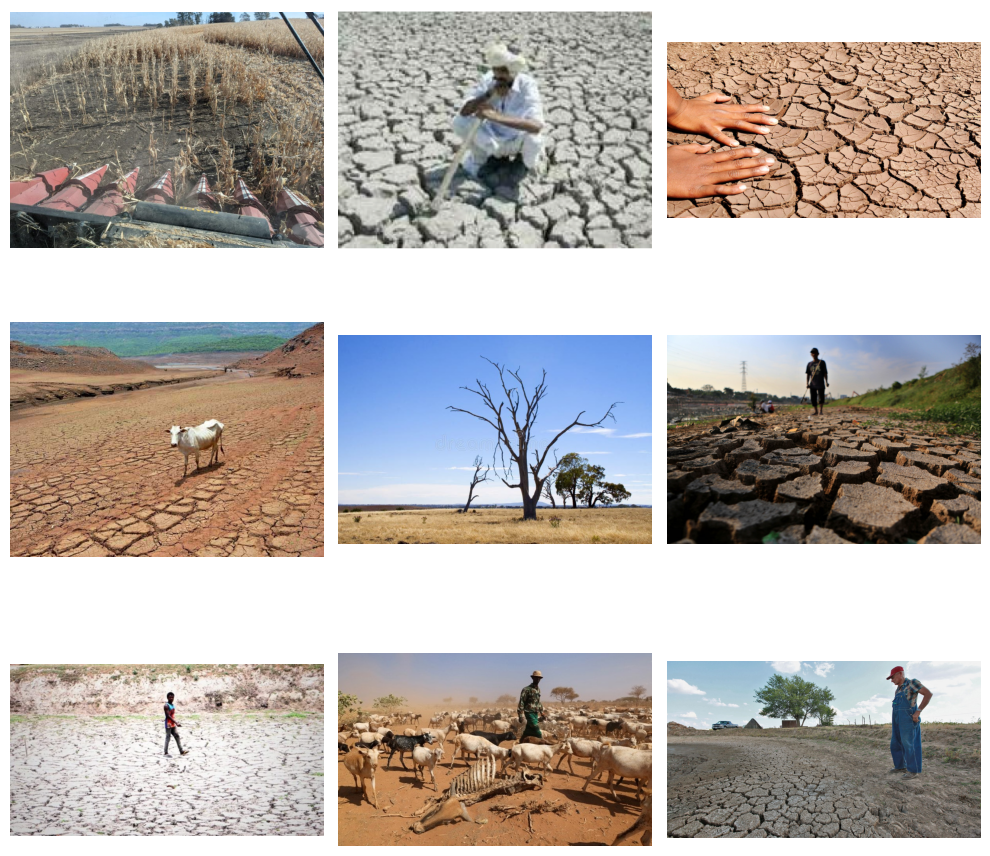

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Directory containing the images
train_directory = "/content/drive/MyDrive/DROUGHT PROJECT/train"

# Get list of image filenames
image_files = os.listdir(train_directory)

# Define the number of rows and columns for the grid
num_rows = 3
num_cols = 3

# Create a new figure
plt.figure(figsize=(10, 10))

# Display images in a grid
for i in range(num_rows * num_cols):
    img_path = os.path.join(train_directory, image_files[i])
    img = mpimg.imread(img_path)
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(img)
    plt.axis('off')

# Show the grid of images
plt.tight_layout()
plt.show()


In [8]:
# import os

# # Check the number of images in the train directory
# train_image_count = sum(len(files) for _, _, files in os.walk(train_directory))
# print("Number of images in train directory:", train_image_count)

# # Check the number of images in the validation directory
# validation_image_count = sum(len(files) for _, _, files in os.walk(validation_directory))
# print("Number of images in validation directory:", validation_image_count)


In [21]:
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
import cv2
import os

# Define the directory containing the image data
base_directory = '/content/drive/MyDrive/DROUGHT PROJECT'

# Get list of all image filenames
image_paths = []
for folder in ['train', 'validation', 'test']:
    folder_directory = os.path.join(base_directory, folder)
    folder_image_paths = [os.path.join(folder_directory, filename) for filename in os.listdir(folder_directory) if filename.endswith('.jpg')]
    image_paths.extend(folder_image_paths)

# Define data augmentation function
def augment_data(image):
    # Apply random noise
    noise_factor = 0.1
    noise = np.random.uniform(-noise_factor, noise_factor, image.shape)
    augmented_image = image + noise

    # Ensure augmented image has the same shape as the original image
    augmented_image = np.clip(augmented_image, 0, 255).astype(np.uint8)

    # Apply color jittering
    augmented_image = cv2.addWeighted(augmented_image, 1.5, np.zeros_like(image), 0, 50)

    # Apply small geometric transformations
    angle = np.random.randint(-5, 5)
    M = cv2.getRotationMatrix2D((image.shape[1] / 2, image.shape[0] / 2), angle, 1)
    augmented_image = cv2.warpAffine(augmented_image, M, (image.shape[1], image.shape[0]))

    return augmented_image


# Load and augment images
augmented_images = []
for image_path in image_paths:
    image = cv2.imread(image_path)
    augmented_image = augment_data(image)
    augmented_images.append(augmented_image)

# Convert images to grayscale
grayscale_images = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in augmented_images]

# Resize grayscale images
resized_images = [cv2.resize(image, (50, 50)) for image in grayscale_images]

# Flatten resized images
flattened_images = [image.flatten() for image in resized_images]

# Feature scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(flattened_images)

# Define and train the One-Class SVM model
clf = OneClassSVM(nu=0.1, kernel='rbf')  # Adjust nu and kernel hyperparameters as needed
clf.fit(scaled_features)

# Example usage for prediction (assuming new image)
new_image_path = "/content/drive/MyDrive/DROUGHT PROJECT/train/image_002.jpg"
new_image = cv2.imread(new_image_path)
new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
new_image_resized = cv2.resize(new_image, (50, 50))
new_image_flattened = new_image_resized.flatten()
new_feature = scaler.transform([new_image_flattened])
prediction = clf.predict(new_feature)[0]

if prediction == 1:
    print("Image classified as drought")
else:
    print("Image classified as non-drought (anomaly)")


Image classified as non-drought (anomaly)


In [22]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from imutils import contours


# Define and fit a KMeans model (adjust number of clusters as needed)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(scaled_features)

# Obtain cluster labels for all data points
cluster_labels = kmeans.labels_

# Calculate silhouette score to assess cluster quality (optional)
silhouette_coeff = silhouette_score(scaled_features, cluster_labels)
print("Silhouette Score:", silhouette_coeff)

# Identify potential non-drought anomalies based on cluster membership
outlier_indices = []
for i, label in enumerate(cluster_labels):
  if label != np.argmax(np.bincount(cluster_labels)):  # Identify the minority cluster
    outlier_indices.append(i)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score: 0.08666990344920779
